In [8]:
import pandas as pd
import numpy as np
import os

## Define file path depending on which index to examine

## SOX
constituents_file_path = "H:/Tech Hardware Shared/$Mike/Quant/Constituents/FTSE250_Constit.csv"
csv_directory = "H:/Tech Hardware Shared/$Mike/Quant/CSV_files/QC"
export_path = "H:/Tech Hardware Shared/$Mike/Quant/Python_Outputs/QC/"
export_audit_file_name = 'QC_Audit.xlsx'
export_output_file_name = 'QC_Output.xlsx'
export_examine_CSV_file_name = 'QC_indiv_CSV.xlsx'

##### CREATING DATABASE DATAFRAME ######

# Read the CSV file into a DataFrame
df = pd.read_csv(constituents_file_path, header=0)
# Convert the column names to datetime with the given format
df.columns = pd.to_datetime(df.columns, format='%d-%b-%y')

# Melt the DataFrame to reshape it
df = pd.melt(df, id_vars=[], var_name='Date', value_name='ISIN')
df['Date'] = df['Date'] + pd.offsets.MonthEnd(0)

# Use a placeholder for NaN values in the 'ISIN' column 
df['ISIN'] = df['ISIN'].fillna('placeholder')

# Create a list to store each ISIN's data
all_isin_data = []

# Iterate through each ISIN in the 'ISIN' column 
for isin in df['ISIN'].unique():
    # Skip if the ISIN is 'placeholder'
    if isin != 'placeholder':
        # Construct the file path for the CSV file
        csv_file_path = os.path.join(csv_directory, f'{isin}.csv')
        # Check if the CSV file exists
        if os.path.exists(csv_file_path):        
            date_columns = ['Date']
            # Read the CSV file 
            isin_data = pd.read_csv(csv_file_path, header=0, na_values=["-"])  # Assuming header is in row 2 and 'Date' is the label
            # Apply the date conversion to all specified columns
            isin_data[date_columns] = isin_data[date_columns].apply(
                pd.to_datetime, unit='D', origin='1899-12-30', errors='coerce'
            )
            # Add month-end adjustment to all date columns
            isin_data[date_columns] = isin_data[date_columns].apply(lambda col: col + pd.offsets.MonthEnd(0) if col.notna().any() else col)
            isin_data['ISIN'] = isin
        
            # Convert all data columns to numeric                   
            numeric_columns = ['Mkt_Cap','RI','P',
                               'Rev_LTM','Rev_NTM',
                               'EBITDA_LTM_DS','EBITDA_LTM','EBITDA_NTM',
                               'EPS_LTM','EPS_NTM',
                               'BPS_LTM','BPS_NTM',
                               'DPS_LTM','DPS_NTM',
                               'CF_LTM_DS','CFPS_LTM','CFPS_NTM',
                               'Assets_LTM',
                               'NetDebt_LTM_DS','NetDebt_LTM','NetDebt_NTM']            
            isin_data[numeric_columns] = isin_data[numeric_columns].apply(lambda x: pd.to_numeric(x, errors='coerce'))

            # Data cleanse
            isin_data['RI'] = np.where(isin_data['RI'] == 0, np.nan, isin_data['RI'])
            isin_data['NetDebt_LTM_Best'] = np.where(pd.notnull(isin_data['NetDebt_LTM']),isin_data['NetDebt_LTM'],isin_data['NetDebt_LTM_DS'])
            isin_data['EBITDA_LTM_Best'] = np.where(pd.notnull(isin_data['EBITDA_LTM']),isin_data['EBITDA_LTM'],isin_data['EBITDA_LTM_DS'])
            isin_data['EV'] = isin_data['Mkt_Cap'] + np.where(pd.notnull(isin_data['NetDebt_NTM']),isin_data['NetDebt_NTM'],isin_data['NetDebt_LTM_Best'])
            #isin_data['EV_LTM'] = isin_data['Mkt_Cap'] + isin_data['NetDebt_LTM_Best']
            #isin_data['EV_NTM'] = isin_data['Mkt_Cap'] + isin_data['NetDebt_NTM']
            
            
            # nix out negative BVPS data
            neg_cols = ['BPS_LTM','BPS_NTM']
            for col in neg_cols:
                isin_data[col] = np.where(isin_data[col] < 0, np.nan, isin_data[col])          
           
            #isin_data['Mkt_Cap_SOM'] = isin_data['Mkt_Cap'].shift(1)
            isin_data['TR'] = isin_data['RI'] / isin_data['RI'].shift(1) -1
            isin_data['TR_LTM'] = isin_data['RI'] / isin_data['RI'].shift(12) -1
            isin_data['EPS_NTM_Chg'] = np.where(isin_data['EPS_NTM'].shift(12) >0,
                                                isin_data['EPS_NTM'] / isin_data['EPS_NTM'].shift(12) -1,
                                                np.nan)
                        
            isin_data['NTM_RevGrowth'] = isin_data['Rev_NTM'] / isin_data['Rev_LTM'] - 1 
            isin_data['Assets_NTM_Raw'] = (1 + isin_data['NTM_RevGrowth']) * isin_data['Assets_LTM']
            isin_data['Assets_NTM'] = (isin_data[['Assets_NTM_Raw', 'Assets_LTM']].max(axis = 1))
                                       
            isin_data['RoE_LTM'] = isin_data['EPS_LTM'] / isin_data['BPS_LTM']
            isin_data['RoE_LTM_5yAvg'] = (isin_data['RoE_LTM'].rolling(window = 60, min_periods = 60).median())
            isin_data['RoE_NTM'] = isin_data['EPS_NTM'] / isin_data['BPS_NTM']
            isin_data['RoE_NTM_5yAvg'] = (isin_data['RoE_NTM'].rolling(window = 60, min_periods = 60).median())
            
            isin_data['Sales_EV_LTM'] = isin_data['Rev_LTM'] / isin_data['EV']
            isin_data['Sales_EV_NTM'] = isin_data['Rev_NTM'] / isin_data['EV']
            
            isin_data['EBITDA_EV_LTM'] = isin_data['EBITDA_LTM_Best'] / isin_data['EV']
            isin_data['EBITDA_EV_NTM'] = isin_data['EBITDA_NTM'] / isin_data['EV']
            
            isin_data['EY_LTM'] = isin_data['EPS_LTM'] / isin_data['P']
            isin_data['EY_NTM'] = isin_data['EPS_NTM'] / isin_data['P']
            
            isin_data['BY_LTM'] = isin_data['BPS_LTM'] / isin_data['P']
            isin_data['BY_NTM'] = isin_data['BPS_NTM'] / isin_data['P']
            
            isin_data['DY_LTM'] = isin_data['DPS_LTM'] / isin_data['P']
            isin_data['DY_NTM'] = isin_data['DPS_NTM'] / isin_data['P']
            
            isin_data['CFY_LTM_IBES'] = isin_data['CFPS_LTM'] / isin_data['P']
            isin_data['CFY_LTM_DS'] = isin_data['CF_LTM_DS'] / isin_data['Mkt_Cap']
            isin_data['CFY_LTM'] = np.where(pd.notnull(isin_data['CFY_LTM_IBES']),
                                            isin_data['CFY_LTM_IBES'],
                                            isin_data['CFY_LTM_DS'])
            isin_data['CFY_NTM'] = isin_data['CFPS_NTM'] / isin_data['P']
            
            isin_data['CF_LTM'] = (isin_data['CFY_LTM'] * isin_data['Mkt_Cap'])
            isin_data['CF_NTM'] = (isin_data['CFY_NTM'] * isin_data['Mkt_Cap'])
            isin_data['CF_Assets_LTM'] = isin_data['CF_LTM'] / isin_data['Assets_LTM']
            isin_data['CF_Assets_NTM'] = isin_data['CF_NTM'] / isin_data['Assets_NTM']
            isin_data['CF_Assets_LTM_5yAvg'] = (isin_data['CF_Assets_LTM'].rolling(window = 60, min_periods = 60).median())
                   
            isin_data['EBITDA_Assets_LTM'] = isin_data['EBITDA_LTM_Best'] / isin_data['Assets_LTM']
            isin_data['EBITDA_Assets_NTM'] = isin_data['EBITDA_NTM'] / isin_data['Assets_NTM']
            isin_data['EBITDA_Assets_LTM_5yAvg'] = (isin_data['EBITDA_Assets_LTM'].rolling(window = 60, min_periods = 60).median())
                                  
            # Define boundary conditions
            clip_conditions = {
            'Sales_EV_NTM': {'lower': -0.02, 'upper': 1},  # Max multiple = -50x, Min multiple = 1x
            'EBITDA_EV_NTM': {'lower': -0.02, 'upper': 1},
            'EY_LTM': {'lower': -0.02, 'upper': 1},
            'EY_NTM': {'lower': -0.02, 'upper': 1},
            'RoE_LTM': {'lower': -0.5, 'upper': 1.5},
            'RoE_NTM': {'lower': -0.5, 'upper': 1.5},
            }

            # Apply clipping to relevant columns
            for col, bounds in clip_conditions.items():
                isin_data[col] = isin_data[col].clip(**bounds)
            
            # Start-of-month list
            SOM_columns = [# Mkt valuation
                           'Mkt_Cap', 'EV',
                            # MTUM
                           'TR_LTM','EPS_NTM_Chg',
                            # Quality
                           'EBITDA_Assets_LTM',       'CF_Assets_LTM',       'RoE_LTM',
                           'EBITDA_Assets_NTM',       'CF_Assets_NTM',       'RoE_NTM',     
                           'EBITDA_Assets_LTM_5yAvg', 'CF_Assets_LTM_5yAvg', 'RoE_LTM_5yAvg',
                           # Value
                           'EBITDA_EV_LTM', 'Sales_EV_LTM', 'CFY_LTM', 'EY_LTM', 'DY_LTM',
                           'EBITDA_EV_NTM', 'Sales_EV_NTM', 'CFY_NTM', 'EY_NTM', 'DY_NTM']
            
            for column in SOM_columns:
                isin_data[column + '_SOM'] = isin_data[column].shift(1)
            
            # Append the data to the list
            all_isin_data.append(isin_data)

# Concatenate all ISIN data into a single DataFrame
isin_final_df = pd.concat(all_isin_data, ignore_index=True)

# Merge the additional columns into the melted DataFrame using 'Date' and 'ISIN' as the keys 
df = pd.merge(df, isin_final_df, on=['Date','ISIN'])

# calculate monthly medians
cols_to_median = ['EBITDA_Assets_LTM_5yAvg_SOM', 'CF_Assets_LTM_5yAvg_SOM', 'RoE_LTM_5yAvg_SOM'] 
for col in cols_to_median:
    median_col_name = f"{col}_Median"
    df[median_col_name] = (
        df.groupby('Date')[col].transform('median')
    )
# Filter for datapoints better than 5y median
df['EBITDA_Assets_LTM_SOM_+'] = np.where(df['EBITDA_Assets_LTM_5yAvg_SOM'] > df['EBITDA_Assets_LTM_5yAvg_SOM_Median'], 
                                         df['EBITDA_Assets_LTM_SOM'],
                                         np.nan)
df['CF_Assets_LTM_SOM_+'] = np.where(df['CF_Assets_LTM_5yAvg_SOM'] > df['CF_Assets_LTM_5yAvg_SOM_Median'], 
                                     df['CF_Assets_LTM_SOM'],
                                     np.nan)
df['RoE_LTM_SOM_+'] = np.where(df['RoE_LTM_5yAvg_SOM'] > df['RoE_LTM_5yAvg_SOM_Median'],
                               df['RoE_LTM_SOM'],
                               np.nan)

df['EBITDA_Assets_NTM_SOM_+'] = np.where(df['EBITDA_Assets_LTM_5yAvg_SOM'] > df['EBITDA_Assets_LTM_5yAvg_SOM_Median'],
                                         df['EBITDA_Assets_NTM_SOM'],
                                         np.nan)
df['CF_Assets_NTM_SOM_+'] = np.where(df['CF_Assets_LTM_5yAvg_SOM'] > df['CF_Assets_LTM_5yAvg_SOM_Median'],
                                     df['CF_Assets_NTM_SOM'],
                                     np.nan)
df['RoE_NTM_SOM_+'] = np.where(df['RoE_LTM_5yAvg_SOM'] > df['RoE_LTM_5yAvg_SOM_Median'],
                               df['RoE_NTM_SOM'],
                               np.nan)

# Display updated dataframe
df.head()

# Export to xlxs
#full_export_path = export_path + export_audit_file_name
#df.to_excel(full_export_path, index=False)



,Date,ISIN,Mkt_Cap,RI,P,Rev_LTM,Rev_NTM,EBITDA_LTM_DS,EBITDA_LTM,EBITDA_NTM,...,DY_NTM_SOM,EBITDA_Assets_LTM_5yAvg_SOM_Median,CF_Assets_LTM_5yAvg_SOM_Median,RoE_LTM_5yAvg_SOM_Median,EBITDA_Assets_LTM_SOM_+,CF_Assets_LTM_SOM_+,RoE_LTM_SOM_+,EBITDA_Assets_NTM_SOM_+,CF_Assets_NTM_SOM_+,RoE_NTM_SOM_+
0,1996-02-29,GB00B4JV1B90,408.03,214.52,0.48,NaN,NaN,47.0,NaN,NaN,...,0.006818,0.131868,0.151304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996-02-29,GB00B06BLB41,521.61,1518.45,45.20,NaN,NaN,NaN,NaN,NaN,...,NaN,0.131868,0.151304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1996-02-29,GB0003396073,317.53,41106.07,0.44,NaN,NaN,62.0,NaN,NaN,...,0.080851,0.131868,0.151304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1996-02-29,GB0000361245,523.54,113.40,1.67,NaN,NaN,65.0,NaN,NaN,...,0.042262,0.131868,0.151304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1996-02-29,GB00B11V7W98,1058.40,6214.38,2.10,NaN,NaN,43.0,NaN,NaN,...,NaN,0.131868,0.151304,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
cols_to_rank = [#MTUM
                'TR_LTM_SOM', 'EPS_NTM_Chg_SOM',
                # Quality
                'EBITDA_Assets_LTM_SOM_+', 'CF_Assets_LTM_SOM_+', 'RoE_LTM_SOM_+', 
                'EBITDA_Assets_NTM_SOM_+', 'CF_Assets_NTM_SOM_+', 'RoE_NTM_SOM_+', 
                # Value
                'Sales_EV_LTM_SOM', 'EBITDA_EV_LTM_SOM', 'EY_LTM_SOM', 'CFY_LTM_SOM', 'DY_LTM_SOM',
                'Sales_EV_NTM_SOM', 'EBITDA_EV_NTM_SOM', 'EY_NTM_SOM', 'CFY_NTM_SOM', 'DY_NTM_SOM']

# Create rank columns grouped by 'Date'
for col in cols_to_rank:
    rank_col_name = f"{col}_Rank"
    df[rank_col_name] = df.groupby('Date')[col].rank(ascending=False, method='min')

# define quality composite ranks
quality_plus_LTM_cols = ['EBITDA_Assets_LTM_SOM_+_Rank', 'CF_Assets_LTM_SOM_+_Rank', 'RoE_LTM_SOM_+_Rank']
n = len(quality_plus_LTM_cols)
df['quality_+_LTM_Rank'] = (df[quality_plus_LTM_cols].apply(lambda row: np.nan if row.count() < (n - 1) else row.nsmallest(n - 1).mean(), axis=1))

quality_plus_NTM_cols = ['EBITDA_Assets_NTM_SOM_+_Rank', 'CF_Assets_NTM_SOM_+_Rank', 'RoE_NTM_SOM_+_Rank']
n = len(quality_plus_NTM_cols)
df['quality_+_NTM_Rank'] = (df[quality_plus_NTM_cols].apply(lambda row: np.nan if row.count() < (n - 1) else row.nsmallest(n - 1).mean(), axis=1))

# define value composite metrics
value_LTM_cols = ['Sales_EV_LTM_SOM_Rank', 'EBITDA_EV_LTM_SOM_Rank', 'EY_LTM_SOM_Rank', 'CFY_LTM_SOM_Rank', 'DY_LTM_SOM_Rank']
n = len(value_LTM_cols)
df['value_+_LTM_Rank'] = (df[value_LTM_cols].apply(lambda row: row.nsmallest(n - 2).mean() if row.count() >= (n - 2) else np.nan, axis=1))

value_NTM_cols = ['Sales_EV_NTM_SOM_Rank', 'EBITDA_EV_NTM_SOM_Rank', 'EY_NTM_SOM_Rank', 'CFY_NTM_SOM_Rank', 'DY_NTM_SOM_Rank']
n = len(value_NTM_cols)
df['value_+_NTM_Rank'] = (df[value_NTM_cols].apply(lambda row: row.nsmallest(n - 2).mean() if row.count() >= (n - 2) else np.nan, axis=1))

# define CoE composite metrics
df['CoE_+_LTM_score'] = df['quality_+_LTM_Rank'] + df['value_+_LTM_Rank']
df['CoE_+_LTM_Rank'] = df.groupby('Date')['CoE_+_LTM_score'].rank(ascending=True, method='min')

df['CoE_+_NTM_score'] = df['quality_+_NTM_Rank'] + df['value_+_NTM_Rank']
df['CoE_+_NTM_Rank'] = df.groupby('Date')['CoE_+_NTM_score'].rank(ascending=True, method='min')

# define MTUM composite metrics
# quality + TR MTUM
df['quality_+_LTM_TR_MTUM_score'] = df['quality_+_LTM_Rank'] + df['TR_LTM_SOM_Rank']
df['quality_+_LTM_TR_MTUM'] = df.groupby('Date')['quality_+_LTM_TR_MTUM_score'].rank(ascending=True, method='min')

df['quality_+_NTM_TR_MTUM_score'] = df['quality_+_NTM_Rank'] + df['TR_LTM_SOM_Rank']
df['quality_+_NTM_TR_MTUM'] = df.groupby('Date')['quality_+_NTM_TR_MTUM_score'].rank(ascending=True, method='min')

# quality + EPS MTUM
df['quality_+_LTM_EPS_MTUM_score'] = df['quality_+_LTM_Rank'] + df['EPS_NTM_Chg_SOM_Rank']
df['quality_+_LTM_EPS_MTUM'] = df.groupby('Date')['quality_+_LTM_EPS_MTUM_score'].rank(ascending=True, method='min')

df['quality_+_NTM_EPS_MTUM_score'] = df['quality_+_NTM_Rank'] + df['EPS_NTM_Chg_SOM_Rank']
df['quality_+_NTM_EPS_MTUM'] = df.groupby('Date')['quality_+_NTM_EPS_MTUM_score'].rank(ascending=True, method='min')

# value + TR MTUM
df['value_+_LTM_TR_MTUM_score'] = df['value_+_LTM_Rank'] + df['TR_LTM_SOM_Rank']
df['value_+_LTM_TR_MTUM'] = df.groupby('Date')['value_+_LTM_TR_MTUM_score'].rank(ascending=True, method='min')

df['value_+_NTM_TR_MTUM_score'] = df['value_+_NTM_Rank'] + df['TR_LTM_SOM_Rank']
df['value_+_NTM_TR_MTUM'] = df.groupby('Date')['value_+_NTM_TR_MTUM_score'].rank(ascending=True, method='min')

# value + EPS MTUM
df['value_+_LTM_EPS_MTUM_score'] = df['value_+_LTM_Rank'] + df['EPS_NTM_Chg_SOM_Rank']
df['value_+_LTM_EPS_MTUM'] = df.groupby('Date')['value_+_LTM_EPS_MTUM_score'].rank(ascending=True, method='min')

df['value_+_NTM_EPS_MTUM_score'] = df['value_+_NTM_Rank'] + df['EPS_NTM_Chg_SOM_Rank']
df['value_+_NTM_EPS_MTUM'] = df.groupby('Date')['value_+_NTM_EPS_MTUM_score'].rank(ascending=True, method='min')

# CoE + TR MTUM
df['CoE_+_LTM_TR_MTUM_score'] = df['CoE_+_LTM_Rank'] + df['TR_LTM_SOM_Rank']
df['CoE_+_LTM_TR_MTUM'] = df.groupby('Date')['CoE_+_LTM_TR_MTUM_score'].rank(ascending=True, method='min')

df['CoE_+_NTM_TR_MTUM_score'] = df['CoE_+_NTM_Rank'] + df['TR_LTM_SOM_Rank']
df['CoE_+_NTM_TR_MTUM'] = df.groupby('Date')['CoE_+_NTM_TR_MTUM_score'].rank(ascending=True, method='min')

# CoE + EPS MTUM
df['CoE_+_LTM_EPS_MTUM_score'] = df['CoE_+_LTM_Rank'] + df['EPS_NTM_Chg_SOM_Rank']
df['CoE_+_LTM_EPS_MTUM'] = df.groupby('Date')['CoE_+_LTM_EPS_MTUM_score'].rank(ascending=True, method='min')

df['CoE_+_NTM_EPS_MTUM_score'] = df['CoE_+_NTM_Rank'] + df['EPS_NTM_Chg_SOM_Rank']
df['CoE_+_NTM_EPS_MTUM'] = df.groupby('Date')['CoE_+_NTM_EPS_MTUM_score'].rank(ascending=True, method='min')

# CoE_TR << maybe do this as the sum of the scores rather than the sum of the ranks.
# this is 50% loaded on MTUM - problem? maybe do it as quality rank + value rank + TR rank + EPS rank? Or do I just get brown?
df['CoE_TR_LTM_score'] = df['quality_+_LTM_TR_MTUM'] + df['value_+_LTM_TR_MTUM']
df['CoE_TR_LTM_Rank'] = df.groupby('Date')['CoE_TR_LTM_score'].rank(ascending=True, method='min')

df['CoE_TR_NTM_score'] = df['quality_+_NTM_TR_MTUM'] + df['value_+_NTM_TR_MTUM']
df['CoE_TR_NTM_Rank'] = df.groupby('Date')['CoE_TR_NTM_score'].rank(ascending=True, method='min')

# CoE_EPS
df['CoE_EPS_LTM_score'] = df['quality_+_LTM_EPS_MTUM'] + df['value_+_LTM_EPS_MTUM']
df['CoE_EPS_LTM_Rank'] = df.groupby('Date')['CoE_EPS_LTM_score'].rank(ascending=True, method='min')

df['CoE_EPS_NTM_score'] = df['quality_+_NTM_EPS_MTUM'] + df['value_+_NTM_EPS_MTUM']
df['CoE_EPS_NTM_Rank'] = df.groupby('Date')['CoE_EPS_NTM_score'].rank(ascending=True, method='min')

# TR + EPS
# CoE + TR MTUM
df['EPS_TR_MTUM_score'] = df['EPS_NTM_Chg_SOM_Rank'] + df['TR_LTM_SOM_Rank']
df['EPS_TR_MTUM'] = df.groupby('Date')['EPS_TR_MTUM_score'].rank(ascending=True, method='min')


# not sure if the composite ranking is fine-grained enough - eg are ranks of 1, 3, 10, 20, 100 condensing down to 1,2,3,4,5?
# I think this is ok except for CoE_TR and CoE_EPS...need to make sure that the ranking is held off as late as possible

#df[['Date', 'ISIN', 'quality_+_LTM_best', 'value_+_LTM_best', 'CoE_+_LTM_score', 'CoE_+_LTM_best', 'TR_LTM_SOM_+']].dropna().head()
#df.head()


In [10]:
# -------------------------------------------------------------
# 0)  WORKING COPY  (keeps your original `df` intact)
# -------------------------------------------------------------
import pandas as pd, numpy as np, pathlib, os
clean = (
    df.copy()
      .assign(Date=lambda x: pd.to_datetime(x['Date']))
      .sort_values(['Date', 'ISIN'])
      .dropna(subset=['TR', 'Mkt_Cap_SOM'])      # exclude rows w/ missing TR or Mcap
      .reset_index(drop=True)
)

# ----- trading cost assumptions (edit here) -----
STAMP_DUTY = 0.0050    # 0.50 %
BID_ASK    = 0.0010    # 0.10 % - this is smaller, assuming MoC trades
FEES       = 0.0010    # 0.10 %

TRADING_COST_RATE = (STAMP_DUTY + BID_ASK + FEES)   

# -------------------------------------------------------------
# 1)  Index market-cap-weighted monthly index
# -------------------------------------------------------------
def index_monthly(frame):
    grp = frame.groupby(pd.Grouper(key='Date', freq='ME'))   # 'ME' = month-end
    sums = grp.agg(weighted_TR=("TR", lambda x: np.sum(x * frame.loc[x.index, 'Mkt_Cap_SOM'])),
                   mkt_sum     =("Mkt_Cap_SOM", "sum"))
    out = (sums['weighted_TR'] / sums['mkt_sum']).rename('Index_TR').to_frame()
    out['Index_Net_NAV'] = (1 + out['Index_TR']).cumprod()
    return out.reset_index()          # Date | Index_TR | Index_NAV

# -------------------------------------------------------------
# 2)  Helper that uses *pre-ranked* columns
#      (lowest rank = best; change ascending=False if higher is better)
# -------------------------------------------------------------
def ranked_factor_series(frame,
                         *,
                         rank_col: str,
                         label:    str,
                         keep_n:   int = 10,
                         screen_n: int = 25,
                         ret_col:  str = 'TR',
                         ascending: bool = True):
    """
    Builds monthly 5-stock portfolio from a PRE-RANKED column.
    Returns Date | <label>_NAV | <label>_Net_NAV
    """
    tmp = frame.copy()
    tmp['Month'] = tmp['Date'].dt.to_period('M')

    # --- screen top `screen_n` each month ---------------------
    top_by_month = {
        m: (block.nsmallest(screen_n, rank_col) if ascending
            else block.nlargest(screen_n, rank_col))[['ISIN', ret_col]]
        for m, block in tmp.groupby('Month')
    }

    rows, prev = [], set()
    for m in sorted(top_by_month):
        cand   = top_by_month[m]
        names  = list(cand['ISIN'])

        keep   = [n for n in names if n in prev]          # survivors
        add    = [n for n in names if n not in prev]
        basket = (keep + add)[:keep_n]

        gross_tr = cand.set_index('ISIN').loc[basket, ret_col].mean()
        churn    = 1 - (len(keep) / keep_n) if prev else 1.0
        net_tr   = gross_tr - TRADING_COST_RATE * churn   # ← cost adjustment

        rows.append({'Date'          : m.to_timestamp('M'),
                     'Gross_TR'      : gross_tr,
                     'Net_TR'        : net_tr})
        prev = set(basket)

    fac = pd.DataFrame(rows).sort_values('Date')
    fac[f'{label}_NAV']     = (1 + fac['Gross_TR']).cumprod()
    fac[f'{label}_Net_NAV'] = (1 + fac['Net_TR']).cumprod()

    # keep only the NAV columns
    return fac[['Date', f'{label}_NAV', f'{label}_Net_NAV']]

# -------------------------------------------------------------
# 3)  <<<  LIST YOUR PRE-RANKED COLUMNS HERE  >>>
# -------------------------------------------------------------
rank_cols_ready = [
    # quality
    'quality_+_LTM_Rank','quality_+_NTM_Rank','quality_+_LTM_TR_MTUM','quality_+_NTM_TR_MTUM','quality_+_LTM_EPS_MTUM','quality_+_NTM_EPS_MTUM',
    # value
    'value_+_LTM_Rank',  'value_+_NTM_Rank',  'value_+_LTM_TR_MTUM',  'value_+_NTM_TR_MTUM',  'value_+_LTM_EPS_MTUM',  'value_+_NTM_EPS_MTUM',
    #CoE
    'CoE_+_LTM_Rank',   'CoE_+_NTM_Rank',     'CoE_+_LTM_TR_MTUM',    'CoE_+_NTM_TR_MTUM',    'CoE_+_LTM_EPS_MTUM',    'CoE_+_NTM_EPS_MTUM',
    # Other
    'CoE_TR_LTM_Rank',  'CoE_TR_NTM_Rank',     'CoE_EPS_LTM_Rank',     'CoE_EPS_NTM_Rank', 
    'TR_LTM_SOM_Rank',  'EPS_NTM_Chg_SOM_Rank','EPS_TR_MTUM'   
]

# -------------------------------------------------------------
# 4)  Build a mini-DataFrame for every ranked factor
# -------------------------------------------------------------
from functools import reduce

factor_frames = [
    ranked_factor_series(clean,
                         rank_col = col,
                         label    = col.replace('_Rank',''),   # strip suffix
                         ascending= True)      # change if larger score = better
    for col in rank_cols_ready
]

factors_df = reduce(lambda l, r: l.merge(r, on='Date', how='left'), factor_frames)

# -------------------------------------------------------------
# 5)  Merge with index (unchanged)
# -------------------------------------------------------------
index_df  = index_monthly(clean)
output_df = index_df.merge(factors_df, on='Date', how='left')

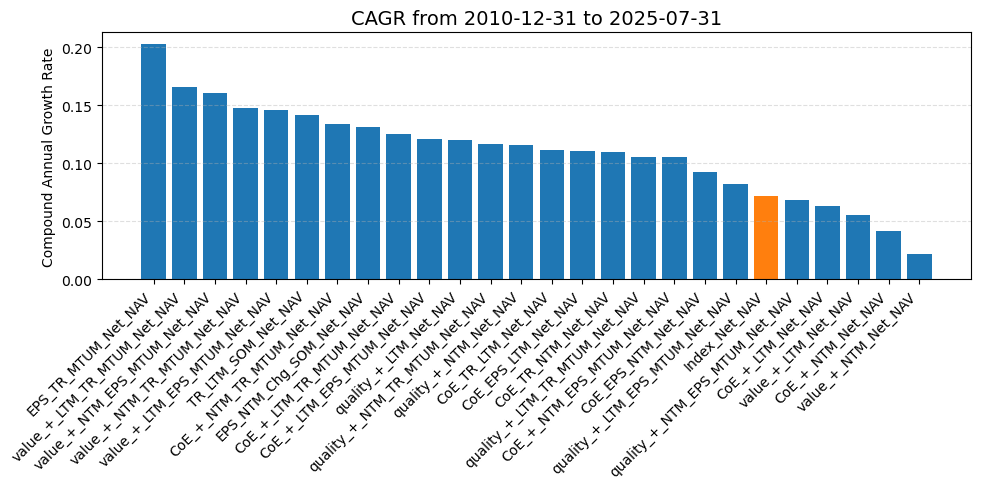

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 0) PARAMETERS  —  edit here only
# ---------------------------------------------------------------------
START_DATE = pd.Timestamp("2010-12-31")   # <- pick your start date
HIGHLIGHT_COLOUR = "tab:orange"           # colour for Index_NAV bar
DEFAULT_COLOUR   = "tab:blue"

# ---------------------------------------------------------------------
# 1) COLLECT NAV COLUMNS & DATE RANGE VALIDATION
# ---------------------------------------------------------------------
nav_cols = [c for c in output_df.columns if c.endswith("_Net_NAV")]
if not nav_cols:
    raise ValueError("No *_NAV columns found in output_df")

# re-index on Date for easy lookup
df = output_df.set_index("Date").sort_index()

if START_DATE not in df.index:
    raise ValueError(
        f"START_DATE {START_DATE.date()} not present in data index.\n"
        "Choose a month-end date that exists."
    )

END_DATE = df.index.max()

# ---------------------------------------------------------------------
# 2) CALCULATE CAGR WITH PER-SERIES DATA-AVAILABILITY CHECK
# ---------------------------------------------------------------------
years = (END_DATE - START_DATE).days / 365.25
cagr_values = {}                # dict: col -> CAGR or NaN

for col in nav_cols:
    series = df[col].dropna()

    # first date this NAV series appears
    first_date = series.index.min()

    if first_date is None or first_date > START_DATE:
        cagr_values[col] = np.nan     # mark as "No Data"
        continue

    start_val = series.loc[:START_DATE].iloc[-1]   # last avail <= START_DATE
    end_val   = series.loc[END_DATE]

    cagr = (end_val / start_val) ** (1 / years) - 1
    cagr_values[col] = cagr

# make a tidy Series and sort
cagr = (pd.Series(cagr_values)
          .dropna()
          .sort_values(ascending=False))

# ---------------------------------------------------------------------
# 3) PLOT  — Index_NAV bar highlighted
# ---------------------------------------------------------------------
bar_colors = [
    HIGHLIGHT_COLOUR if col == "Index_Net_NAV" else DEFAULT_COLOUR
    for col in cagr.index
]

plt.figure(figsize=(10, 5))
plt.bar(cagr.index, cagr.values, color=bar_colors)
plt.title(f"CAGR from {START_DATE.date()} to {END_DATE.date()}", fontsize=14)
plt.ylabel("Compound Annual Growth Rate")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



In [12]:

# ---------------------------------------------------------------------
# OPTIMISE FACTORS
# ---------------------------------------------------------------------

# Step 1: Identify the target columns
net_nav_cols = [col for col in output_df.columns 
                if col.endswith('Net_NAV') and col != 'Index_Net_NAV']

# Step 2: Calculate 1m return and 12m return (from previous month)
for col in net_nav_cols:
    output_df[f'{col}_1m_return'] = output_df[col] / output_df[col].shift(1) - 1
    output_df[f'{col}_12m_return'] = output_df[col].shift(1) / output_df[col].shift(13) - 1

# Step 3: For each row, select top half of columns by 12m return and average their 1m returns
def calc_filtered_net_tr(row):
    twelve_month_returns = row[[f'{col}_12m_return' for col in net_nav_cols]]
    one_month_returns = row[[f'{col}_1m_return' for col in net_nav_cols]]
    
    # Get indices of top half 12m returns
    top_half_idx = twelve_month_returns.sort_values(ascending=False).index[:len(twelve_month_returns) // 2]
    top_half_1m_returns = one_month_returns[top_half_idx.str.replace('_12m_return', '_1m_return')]
    
    return top_half_1m_returns.mean()

output_df['Filtered_Net_TR'] = output_df.apply(calc_filtered_net_tr, axis=1)

# Step 4: Calculate Filtered_Net_NAV from Filtered_Net_TR
# We assume initial NAV = 1 and compound monthly returns
output_df['Filtered_Net_NAV'] = (1 + output_df['Filtered_Net_TR']).cumprod()
output_df['Filtered_Net_NAV_Rel'] = output_df['Filtered_Net_NAV'] / output_df['Index_Net_NAV']



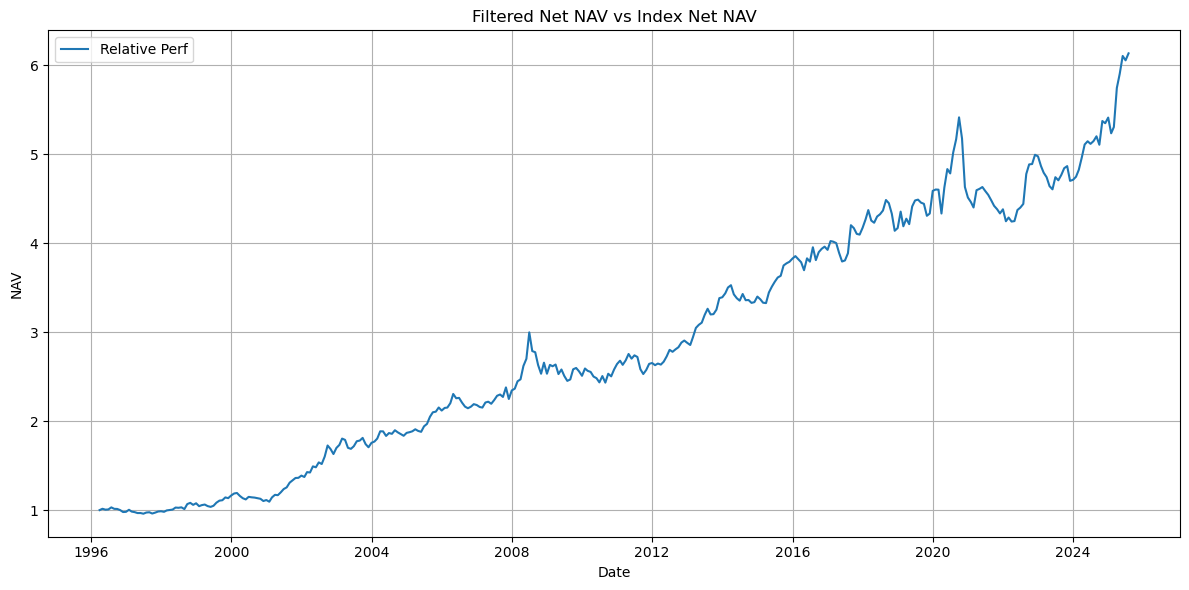

In [13]:
import matplotlib.pyplot as plt

# Plot Filtered_Net_NAV vs Index_Net_NAV
plt.figure(figsize=(12, 6))
plt.plot(output_df['Date'], output_df['Filtered_Net_NAV_Rel'], label='Relative Perf')
plt.xlabel('Date')
plt.ylabel('NAV')
plt.title('Filtered Net NAV vs Index Net NAV')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [95]:
# Export to xlxs
full_export_path = export_path + export_output_file_name
output_df.to_excel(full_export_path, index=False)



In [11]:
# examine stock by stock data for a single month
examine_data = df[(df['Date'] >= '2024-03-31') & (df['Date'] <= '2024-03-31')]

# Export to xlsx
full_export_path = export_path + export_examine_CSV_file_name
examine_data.to_excel(full_export_path, index=False)

In [9]:
print("df.shape ->", df.shape)

df.shape -> (88236, 105)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88236 entries, 0 to 88235
Columns: 105 entries, Date to RoE_NTM_SOM_+
dtypes: datetime64[ns](1), float64(103), object(1)
memory usage: 70.7+ MB


In [7]:
print(df.head(8).to_string()) 

        Date          ISIN  Mkt_Cap        RI      P  Rev_LTM  Rev_NTM  EBITDA_LTM_DS  EBITDA_LTM  EBITDA_NTM  EPS_LTM  EPS_NTM  BPS_LTM  BPS_NTM  DPS_LTM  DPS_NTM  CF_LTM_DS  CFPS_LTM  CFPS_NTM  Assets_LTM  NetDebt_LTM_DS  NetDebt_LTM  NetDebt_NTM  NetDebt_LTM_Best  EBITDA_LTM_Best      EV        TR    TR_LTM    TR_L6M    TR_L3M       PCH   PCH_LTM   PCH_L6M   PCH_L3M  NTM_RevGrowth  LTM_EBITDA_Margin  NTM_EBITDA_Margin  RoE_LTM  RoE_LTM_5yAvg  RoE_NTM  RoE_NTM_5yAvg  Sales_EV_LTM  Sales_EV_NTM  EBITDA_EV_LTM  EBITDA_EV_NTM    EY_LTM    EY_NTM  BY_LTM  BY_NTM    DY_LTM    DY_NTM  CFY_LTM_IBES  CFY_LTM_DS   CFY_LTM   CFY_NTM     CF_LTM  CF_Assets_LTM  CF_Assets_LTM_5yAvg  CF_BV_NTM  CF_BV_NTM_5yAvg  EBITDA_Assets_LTM  EBITDA_Assets_LTM_5yAvg  EBITDA_BV_NTM  EBITDA_BV_NTM_5yAvg  Mkt_Cap_SOM  TR_LTM_SOM  TR_L6M_SOM  TR_L3M_SOM  EBITDA_Assets_LTM_SOM  CF_Assets_LTM_SOM  RoE_LTM_SOM  EBITDA_Assets_LTM_5yAvg_SOM  CF_Assets_LTM_5yAvg_SOM  RoE_LTM_5yAvg_SOM  EBITDA_BV_NTM_SOM  CF_BV_NTM_SOM  

In [11]:
numeric_summary = df.describe().T          # numeric cols only
print(numeric_summary.head(25).to_string())

C:\Users\mike.harrison\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\mike.harrison\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


                    count                           mean                  min                  25%                  50%                  75%                  max            std
Date                88236  2010-10-13 04:27:35.813953536  1996-02-29 00:00:00  2003-06-30 00:00:00  2010-09-30 00:00:00  2018-01-31 00:00:00  2025-05-31 00:00:00            NaN
Mkt_Cap           86717.0                    1164.835118                 0.03               539.04               909.92              1514.07             27898.43     894.772539
RI                86717.0                   24149.301516                 0.01               233.97              1194.37              10661.1            6257235.0  139454.692349
P                 86718.0                       8.361694                  0.0                 1.63                 3.13                 6.03             31249.37     175.832523
Rev_LTM           68029.0                    1246.556847             -1840.03              301.618              695

In [ ]:
# ------------- old analysis below

In [4]:
# --------------------------------------------------
n_keep   = 5                                      # top-5 rule
base_ret = 'TR'                                   # raw return column
rank_cols = [f"{c}_Rank" for c in cols_to_rank]   # same list you built
mkt_cap = 'Mkt_Cap_SOM'
# --------------------------------------------------

# ---------- define functions --------------------
def wavg_tr(month_df):
    good = month_df[[base_ret, mkt_cap]].dropna()
    if good.empty:
        return 0.0
    return np.average(good[base_ret], weights=good[mkt_cap])

def monthly_top_n_tr(month_df: pd.DataFrame, rank_col: str, n: int) -> float:
    """
    One-month helper: average TR of the n lowest ranks.
    NaN rows in either rank or TR are ignored automatically.
    """
    picks = month_df.nsmallest(n, rank_col).index          # n best rows
    return month_df.loc[picks, base_ret].mean()

def series_from_rank(df: pd.DataFrame, rank_col: str, n: int):
    """
    Build monthly TR + cumulative NAV for one rank column.
    """
    tr = (df.groupby('Date', group_keys=False)
            .apply(monthly_top_n_tr, rank_col, n, include_groups=False)
            .fillna(0))                # missing month => 0 % return

    nav = (1 + tr).cumprod()

    # nice label: strip the '_Rank' suffix
    label_root = rank_col.replace('_Rank', '')
    return pd.DataFrame({f'{label_root}_TR':  tr,
                         f'{label_root}_NAV': nav})

# ---------- build market-cap-weighted index --------------------

index_tr = (df.groupby('Date', group_keys=False)
              .apply(wavg_tr, include_groups=False)
              .fillna(0))

index_nav = (1 + index_tr).cumprod()

df_output = pd.DataFrame({
    'Date'     : index_tr.index,
    'Index_TR' : index_tr.values,
    'Index_NAV': index_nav.values
})

#df_output.head()

# Export to xlxs
full_export_path = export_path + export_index_file_name
df_output.to_excel(full_export_path, index=False)

# ---------- examine momentum factor --------------------

cols_to_rank = ['TR_LTM_SOM', 'TR_LTM_SOM_+']

# Create rank columns grouped by 'Date'
for col in cols_to_rank:
    rank_col_name = f"{col}_Rank"
    df[rank_col_name] = df.groupby('Date')[col].rank(ascending=False, method='min')

# ------------ run for every rank column --------------------------
frames = [series_from_rank(df, rc, n_keep) for rc in rank_cols]
df_output_indiv = pd.concat(frames, axis=1).reset_index()   # Date preserved

# join index to df_output_indiv
df_output_indiv = (
    df_index.set_index('Date')           # use Date as join key
    .join(df_output_indiv.set_index('Date'), how='left')
    .reset_index()                       # bring Date back as a column
)



In [19]:
cols_to_rank = ['EBITDA_Assets_LTM_SOM', 'CF_Assets_LTM_SOM', 'RoE_LTM_SOM',
                'EBITDA_Assets_LTM_SOM_+', 'CF_Assets_LTM_SOM_+', 'RoE_LTM_SOM_+', 
                'EBITDA_BV_NTM_SOM', 'CF_BV_NTM_SOM', 'RoE_NTM_SOM',
                'EBITDA_BV_NTM_SOM_+', 'CF_BV_NTM_SOM_+', 'RoE_NTM_SOM_+',
                'Sales_EV_LTM_SOM', 'EBITDA_EV_LTM_SOM', 'EY_LTM_SOM', 'CFY_LTM_SOM',
                'Sales_EV_NTM_SOM', 'EBITDA_EV_NTM_SOM', 'EY_NTM_SOM', 'CFY_NTM_SOM',
                'TR_LTM_SOM', 'TR_LTM_SOM_+']

# Create rank columns grouped by 'Date'
for col in cols_to_rank:
    rank_col_name = f"{col}_Rank"
    df[rank_col_name] = df.groupby('Date')[col].rank(ascending=False, method='min')


# --------------------------------------------------
n_keep   = 5                                      # top-5 rule
base_ret = 'TR'                                   # raw return column
rank_cols = [f"{c}_Rank" for c in cols_to_rank]   # same list you built
mkt_cap = 'Mkt_Cap_SOM'
# --------------------------------------------------

def monthly_top_n_tr(month_df: pd.DataFrame, rank_col: str, n: int) -> float:
    """
    One-month helper: average TR of the n lowest ranks.
    NaN rows in either rank or TR are ignored automatically.
    """
    picks = month_df.nsmallest(n, rank_col).index          # n best rows
    return month_df.loc[picks, base_ret].mean()

def series_from_rank(df: pd.DataFrame, rank_col: str, n: int):
    """
    Build monthly TR + cumulative NAV for one rank column.
    """
    tr = (df.groupby('Date', group_keys=False)
            .apply(monthly_top_n_tr, rank_col, n, include_groups=False)
            .fillna(0))                # missing month => 0 % return

    nav = (1 + tr).cumprod()

    # nice label: strip the '_Rank' suffix
    label_root = rank_col.replace('_Rank', '')
    return pd.DataFrame({f'{label_root}_TR':  tr,
                         f'{label_root}_NAV': nav})

# ------------ run for every rank column --------------------------
frames = [series_from_rank(df, rc, n_keep) for rc in rank_cols]
df_output_indiv = pd.concat(frames, axis=1).reset_index()   # Date preserved


# ---------- build market-cap-weighted index --------------------
def wavg_tr(month_df):
    good = month_df[[base_ret, mkt_cap]].dropna()
    if good.empty:
        return 0.0
    return np.average(good[base_ret], weights=good[mkt_cap])

index_tr = (df.groupby('Date', group_keys=False)
              .apply(wavg_tr, include_groups=False)
              .fillna(0))

index_nav = (1 + index_tr).cumprod()

df_index = pd.DataFrame({
    'Date'     : index_tr.index,
    'Index_TR' : index_tr.values,
    'Index_NAV': index_nav.values
})

# join index to df_output_indiv
df_output_indiv = (
    df_index.set_index('Date')           # use Date as join key
    .join(df_output_indiv.set_index('Date'), how='left')
    .reset_index()                       # bring Date back as a column
)


# quick peek
print(df_output_indiv.head())


        Date  Index_TR  Index_NAV  EBITDA_Assets_LTM_SOM_TR  \
0 1996-02-29  0.020661   1.020661                  0.051356   
1 1996-03-31  0.031272   1.052579                  0.029794   
2 1996-04-30  0.056550   1.112102                  0.135298   
3 1996-05-31 -0.003933   1.107728                  0.046434   
4 1996-06-30 -0.030973   1.073419                 -0.030535   

   EBITDA_Assets_LTM_SOM_NAV  CF_Assets_LTM_SOM_TR  CF_Assets_LTM_SOM_NAV  \
0                   1.051356              0.028977               1.028977   
1                   1.082680             -0.003026               1.025864   
2                   1.229165              0.120732               1.149719   
3                   1.286240              0.015419               1.167446   
4                   1.246965             -0.027037               1.135881   

   RoE_LTM_SOM_TR  RoE_LTM_SOM_NAV  EBITDA_Assets_LTM_SOM_+_TR  ...  \
0        0.012396         1.012396                    0.055162  ...   
1        0.02377

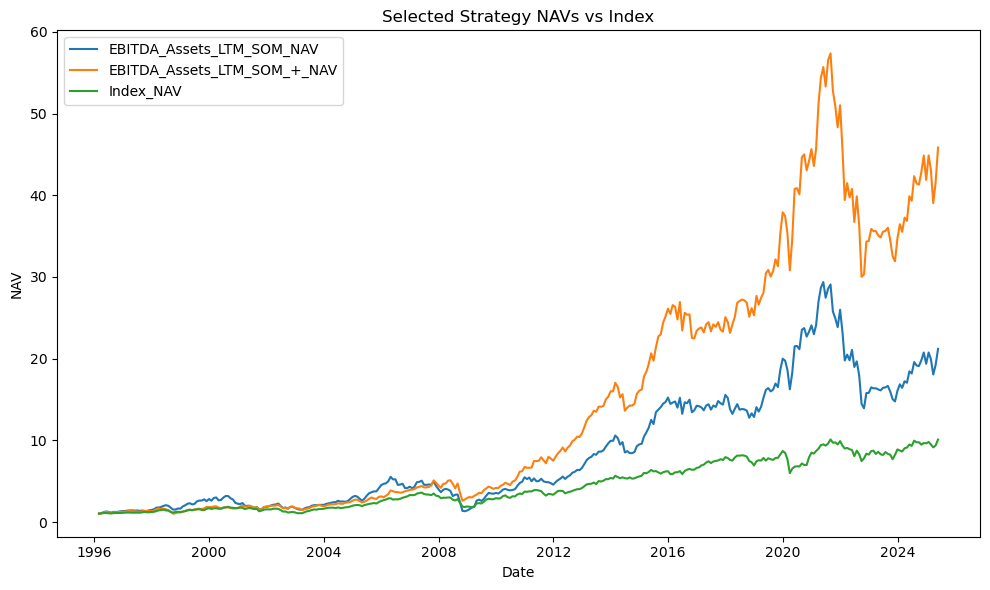

In [29]:
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1)  list the series you actually want to see
series_to_plot = [
    'EBITDA_Assets_LTM_SOM_NAV', 'EBITDA_Assets_LTM_SOM_+_NAV',
    'Index_NAV'                    
]
# ------------------------------------------------------------

missing = [s for s in series_to_plot if s not in df_output_indiv.columns]
if missing:
    raise ValueError(f"Not found in df_output_indiv: {missing}")

plot_df = df_output_indiv.set_index('Date')[series_to_plot]

plt.figure(figsize=(10, 6))
for col in series_to_plot:
    plt.plot(plot_df.index, plot_df[col], label=col)

plt.xlabel('Date')
plt.ylabel('NAV')
plt.title('Selected Strategy NAVs vs Index')
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import pandas as pd

# --------------- user knobs -----------------
n        = 5           # keep n lowest ranks in each factor
dedupe   = True        # True = a stock counted once per month
base_ret = 'TR'        # raw total-return column
mkt_cap  = 'Mkt_Cap_SOM'
# --------------------------------------------

factor_sets = {
    "LTM"    : ['quality_LTM_best',   'value_LTM_best',   'CoE_LTM_best',   'TR_LTM_SOM_+'],
    "LTM_+"  : ['quality_+_LTM_best', 'value_+_LTM_best', 'CoE_+_LTM_best', 'TR_LTM_SOM_+'],
    "NTM"    : ['quality_NTM_best',   'value_NTM_best',   'CoE_NTM_best',   'TR_LTM_SOM_+'],
    "NTM_+"  : ['quality_+_NTM_best', 'value_+_NTM_best', 'CoE_+_NTM_best', 'TR_LTM_SOM_+'],

    "LTM_mtum"    : ['quality_LTM_MTUM_best',   'value_LTM_MTUM_best',   'CoE_LTM_MTUM_best',   'TR_LTM_SOM_+'],
    "LTM_+_mtum"  : ['quality_+_LTM_MTUM_best', 'value_+_LTM_MTUM_best', 'CoE_+_LTM_MTUM_best', 'TR_LTM_SOM_+'],
    "NTM_mtum"    : ['quality_NTM_MTUM_best',   'value_NTM_MTUM_best',   'CoE_NTM_MTUM_best',   'TR_LTM_SOM_+'],
    "NTM_+_mtum"  : ['quality_+_NTM_MTUM_best', 'value_+_NTM_MTUM_best', 'CoE_+_NTM_MTUM_best', 'TR_LTM_SOM_+'],
}
# ---------- helper: average TR of picks in ONE month -------------
def basket_series(month_df: pd.DataFrame,
                  rank_cols: list[str],
                  n_keep: int,
                  dedupe: bool) -> float:
    picks = []
    for col in rank_cols:
        picks.extend(month_df.nsmallest(n_keep, col).index)
    if dedupe:
        picks = np.unique(picks)
    return month_df.loc[picks, base_ret].mean()

# ---------- wrapper: build TR + NAV for one basket ----------------
def build_tr_nav(df, rank_cols, n_keep, label, dedupe):
    tr = (df.groupby('Date', group_keys=False)
            .apply(basket_series, rank_cols, n_keep, dedupe,
                   include_groups=False)          # silences deprecation warn
            .fillna(0) )                          # NaN ⇒ 0 % monthly return
    nav = (1 + tr).cumprod()
    return pd.DataFrame({f'{label}_TR': tr,
                         f'{label}_NAV': nav})

# ---------- run all baskets ---------------------------------------
out_frames = [
    build_tr_nav(df, cols, n, name, dedupe)
    for name, cols in factor_sets.items()
]
df_output = pd.concat(out_frames, axis=1).reset_index()   # Date retained

# ---------- 1) build market-cap-weighted index --------------------
def wavg_tr(month_df):
    good = month_df[[base_ret, mkt_cap]].dropna()
    if good.empty:
        return 0.0
    return np.average(good[base_ret], weights=good[mkt_cap])

index_tr = (df.groupby('Date', group_keys=False)
              .apply(wavg_tr, include_groups=False)
              .fillna(0))

index_nav = (1 + index_tr).cumprod()

df_index = pd.DataFrame({
    'Date'     : index_tr.index,
    'Index_TR' : index_tr.values,
    'Index_NAV': index_nav.values
})

# ---------- 2) append to df_output with aligned dates -------------
df_output = df_output.merge(df_index, on='Date', how='left')

# ---------- 3) add relative-performance columns -------------------
for col in df_output.filter(like='_NAV').columns:
    if col == 'Index_NAV':
        continue
    rel_col = col.replace('_NAV', '_Rel')
    df_output[rel_col] = df_output[col] / df_output['Index_NAV']

# df_output now contains:
# Date  |  LTM_TR  LTM_NAV …  Index_TR Index_NAV  LTM_Rel  LTM+_Rel … etc.


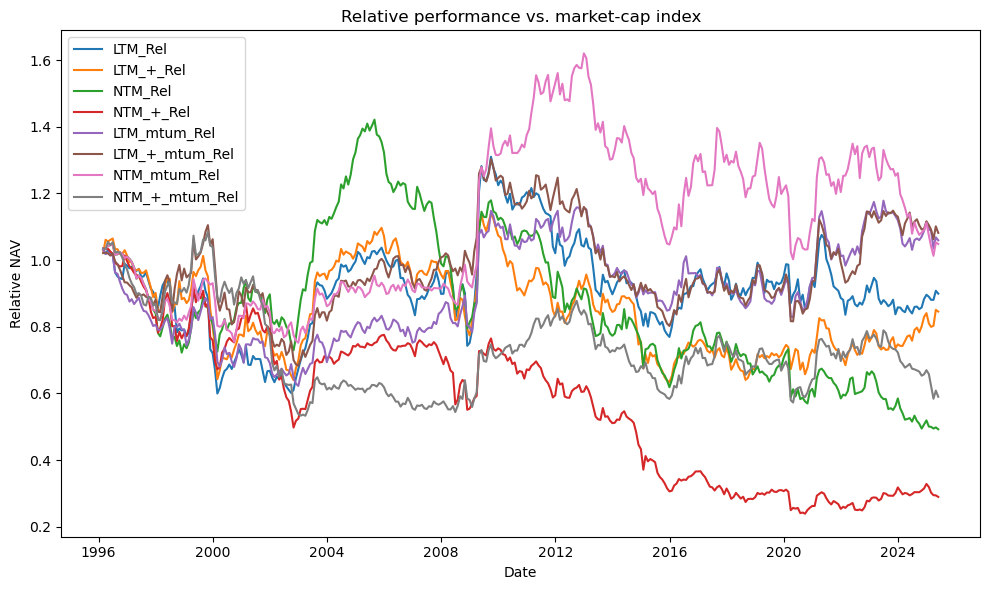

In [14]:
import matplotlib.pyplot as plt

# 1. pick only the “_Rel” series
rel_cols = [c for c in df_output.columns if c.endswith('_Rel')]

# 2. make Date the index for nice x-axis ticks
plot_df = df_output.set_index('Date')[rel_cols]

# 3. one chart, one line per strategy
plt.figure(figsize=(10, 6))
for col in rel_cols:
    plt.plot(plot_df.index, plot_df[col], label=col)

plt.xlabel('Date')
plt.ylabel('Relative NAV')
plt.title('Relative performance vs. market-cap index')
plt.legend()
plt.tight_layout()
plt.show()


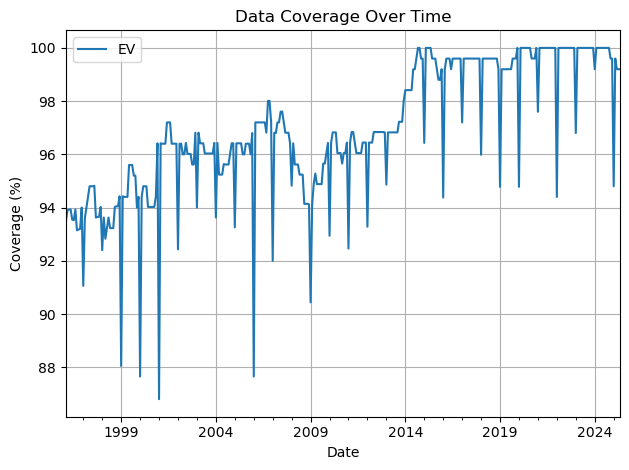

In [5]:
# Data audit
import matplotlib.pyplot as plt

# Example inputs
cols_to_check = ['EV']
date_col = 'Date'

# Ensure Date column is datetime
df[date_col] = pd.to_datetime(df[date_col])

# Group by date
grouped = df.groupby(date_col)

# Calculate non-NaN counts and total counts for each group
coverage = grouped[cols_to_check].apply(lambda x: x.notna().sum() / len(x) * 100)

# Plotting
coverage.plot()
plt.ylabel('Coverage (%)')
plt.title('Data Coverage Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()






In [5]:
### LONG / SHORT RETURNS BY VARIABLE --- nTH SEGMENTATION ###

# List of target columns
target_columns = [
    'Mkt_Cap_SOM', 'TR_LTM_SOM', 'TR_L6M_SOM', 'TR_L3M_SOM', 'NTM_RevGrowth_SOM', 
    'NTM_EBITDA_Margin_SOM', 'RoE_NTM_SOM', 'NTM_RevGrowth_3mChg_SOM', 
    'NTM_Rev_3mChg_SOM', 'NTM_EBITDA_Margin_3mChg_SOM', 'Sales_EV_NTM_SOM', 
    'EBITDA_EV_NTM_SOM', 'EY_NTM_SOM', 'EY_2yFwd_SOM', 'BY_NTM_SOM', 'CoE_SOM', 
    'Implied_G_SOM', 'Rev_MTUM_SOM', 'EPS_MTUM_SOM'
]

# Initialize the final results DataFrame with unique dates
nth_LS_results_df = pd.DataFrame(df['Date'].unique(), columns=['Date'])

# Ensure 'Date' in the main DataFrame is of datetime type
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Define the Nth largest/smallest value threshold
n = 5  # Change this value for different thresholds

# Iterate over each target column
for target_column in target_columns:
    # Ensure the target column and 'TR' are numeric
    df[target_column] = pd.to_numeric(df[target_column], errors='coerce')
    df['TR'] = pd.to_numeric(df['TR'], errors='coerce')

    # List to collect results for each date
    results = []

    # Group by 'Date' to calculate metrics for each target column
    for date, group in df.groupby('Date'):
        # Drop NaNs in the target column for this group
        group = group.dropna(subset=[target_column])

        # Ensure there are enough data points to calculate the Nth largest/smallest
        if len(group) < n:
            continue

        # Get the threshold values for the Nth largest and smallest
        nth_largest = group[target_column].nlargest(n).min()  # Nth largest value
        nth_smallest = group[target_column].nsmallest(n).max()  # Nth smallest value

        # Calculate TR for the 'Long' and 'Short' conditions
        long_nth_tr = group[group[target_column] >= nth_largest]['TR'].mean()
        short_nth_tr = group[group[target_column] <= nth_smallest]['TR'].mean()

        # Append results for the current date
        results.append({
            'Date': date,
            f'Long_{target_column}': long_nth_tr,
            f'Short_{target_column}': short_nth_tr
        })

    # Convert the results list to a DataFrame
    target_df = pd.DataFrame(results)

    # Calculate the Long-Short (LS) column
    target_df[f'LS_{target_column}'] = (
        (1 + target_df[f'Long_{target_column}']) / (1 + target_df[f'Short_{target_column}']) - 1
    )

    # Merge the current target column results into the final results DataFrame
    nth_LS_results_df = pd.merge(nth_LS_results_df, target_df, on='Date', how='left')

# Display or save the final results
#nth_LS_results_df.tail()

# Export to xlxs
full_export_path = export_path + export_nth_LS_file_name 
nth_LS_results_df.to_excel(full_export_path, index=False)

In [ ]:
# Need a backward looking and forward looking version
# on compound parameters, need to get ranking the correct way around to work with the nth ranking below
# error correction...particularly with forward looking version...need a counter to track what proportion of index participants have data for relevant date
# before doing the return calculation need a data frame that groups by date and counts how many non-NaN values there are
# maybe even put this in when initial df is created - ie do this before compound parameters are calculated
# maybe have the data presented as a line chart

## CREATE COMPOSITE RANKINGS HERE
## GROUP BY MONTH
## RANK EACH VARIABLE
## COMPOSITE RANKING FOR VALUE, VALUE+, QUALITY, QUALITY+, MTUM, MTUM+
## THEN RANKING FOR COE and COE+
## THEN RANKING FOR VALUE_MTUM, QUALITY_MTUM etc

## NEED 5y AVG FOR EBITDA / ASSETS - PUT IN CODE ABOVE
## NEED MONTHLY AVG FOR THE GROUP - PUT HERE


In [6]:
### CHURN ANALYSIS BY VARIABLE --- nTH SEGMENTATION ###

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Define parameters
target_columns = [
    'Mkt_Cap_SOM', 'TR_LTM_SOM', 'TR_L6M_SOM', 'TR_L3M_SOM', 'NTM_RevGrowth_SOM', 
    'NTM_EBITDA_Margin_SOM', 'RoE_NTM_SOM', 'NTM_RevGrowth_3mChg_SOM', 
    'NTM_Rev_3mChg_SOM', 'NTM_EBITDA_Margin_3mChg_SOM', 'Sales_EV_NTM_SOM', 
    'EBITDA_EV_NTM_SOM', 'EY_NTM_SOM', 'EY_2yFwd_SOM', 'BY_NTM_SOM', 'CoE_SOM', 
    'Implied_G_SOM', 'Rev_MTUM_SOM', 'EPS_MTUM_SOM'
]
n = 5  # Number of top/bottom ISINs to track
results = []

# Iterate over target columns
for target_column in target_columns:
    # Ensure the target column is numeric
    df[target_column] = pd.to_numeric(df[target_column], errors='coerce')
    
    # Sort by Date for consistency
    df = df.sort_values('Date')
    
    # Compute top_n and bottom_n for each Date
    top_n_dict = {}
    bottom_n_dict = {}
    for date, group in df.groupby('Date'):
        # Get top N ISINs
        top_n = group.nlargest(n, target_column)['ISIN'].tolist()
        top_n_dict[date] = set(top_n)
        
        # Get bottom N ISINs
        bottom_n = group.nsmallest(n, target_column)['ISIN'].tolist()
        bottom_n_dict[date] = set(bottom_n)
    
    # Compare across consecutive dates
    sorted_dates = sorted(top_n_dict.keys())
    for i in range(1, len(sorted_dates)):
        prev_date = sorted_dates[i - 1]
        curr_date = sorted_dates[i]
        
        # Calculate LongChurn (Top N)
        prev_top_n = top_n_dict[prev_date]
        curr_top_n = top_n_dict[curr_date]
        new_entries_top = curr_top_n - prev_top_n
        long_churn_proportion = len(new_entries_top) / n
        
        # Calculate ShortChurn (Bottom N)
        prev_bottom_n = bottom_n_dict[prev_date]
        curr_bottom_n = bottom_n_dict[curr_date]
        new_entries_bottom = curr_bottom_n - prev_bottom_n
        short_churn_proportion = len(new_entries_bottom) / n
        
        # Calculate Average Churn
        avg_churn_proportion = (long_churn_proportion + short_churn_proportion) / 2
        
        # Record results for both LongChurn, ShortChurn, and Average Churn
        results.append({
            'Date': curr_date,
            f'Long_{target_column}': long_churn_proportion,
            f'Short_{target_column}': short_churn_proportion,
            f'LS_{target_column}': avg_churn_proportion
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Combine all LongChurn, ShortChurn, and AverageChurn columns side by side
nth_churn_df = results_df.groupby('Date', as_index=False).first()

# Display the final DataFrame
#nth_churn_df.tail()

# Export to xlxs
full_export_path = export_path + export_nth_churn_file_name 
nth_churn_df.to_excel(full_export_path, index=False)